**Binary classification if tomorrows closing price will go up or down**

In [53]:
import sys
import os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch.optim as optim
import pandas_ta as ta
# from data.handling import DataSet_stock
# from data.handling import create_series
from models.lstm_models import LSTM_Model_Classification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
STOCK_NAME = "Apple"
STOCK = "aapl"
stock_day = yf.download(STOCK, interval="1d", period="max")
stock_minute = yf.download(STOCK, interval='1m', period='8d')
stock_hour = yf.download(STOCK, interval = '1h', period='730d')

stock_day.columns = [col[0] for col in stock_day.columns]
stock_minute.columns = [col[0] for col in stock_minute.columns]
stock_hour.columns = [col[0] for col in stock_hour.columns]

stock_day.head()

C:\Users\knutr\AppData\Local\Temp\ipykernel_13028\1905626866.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_day = yf.download(STOCK, interval="1d", period="max")
[*********************100%***********************]  1 of 1 completed
C:\Users\knutr\AppData\Local\Temp\ipykernel_13028\1905626866.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_minute = yf.download(STOCK, interval='1m', period='8d')
[*********************100%***********************]  1 of 1 completed
C:\Users\knutr\AppData\Local\Temp\ipykernel_13028\1905626866.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_hour = yf.download(STOCK, interval = '1h', period='730d')
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
1980-12-12,0.098597,0.099025,0.098597,0.098597,469033600
1980-12-15,0.093453,0.093881,0.093453,0.093881,175884800
1980-12-16,0.086594,0.087022,0.086594,0.087022,105728000
1980-12-17,0.088737,0.089165,0.088737,0.088737,86441600
1980-12-18,0.091309,0.091738,0.091309,0.091309,73449600


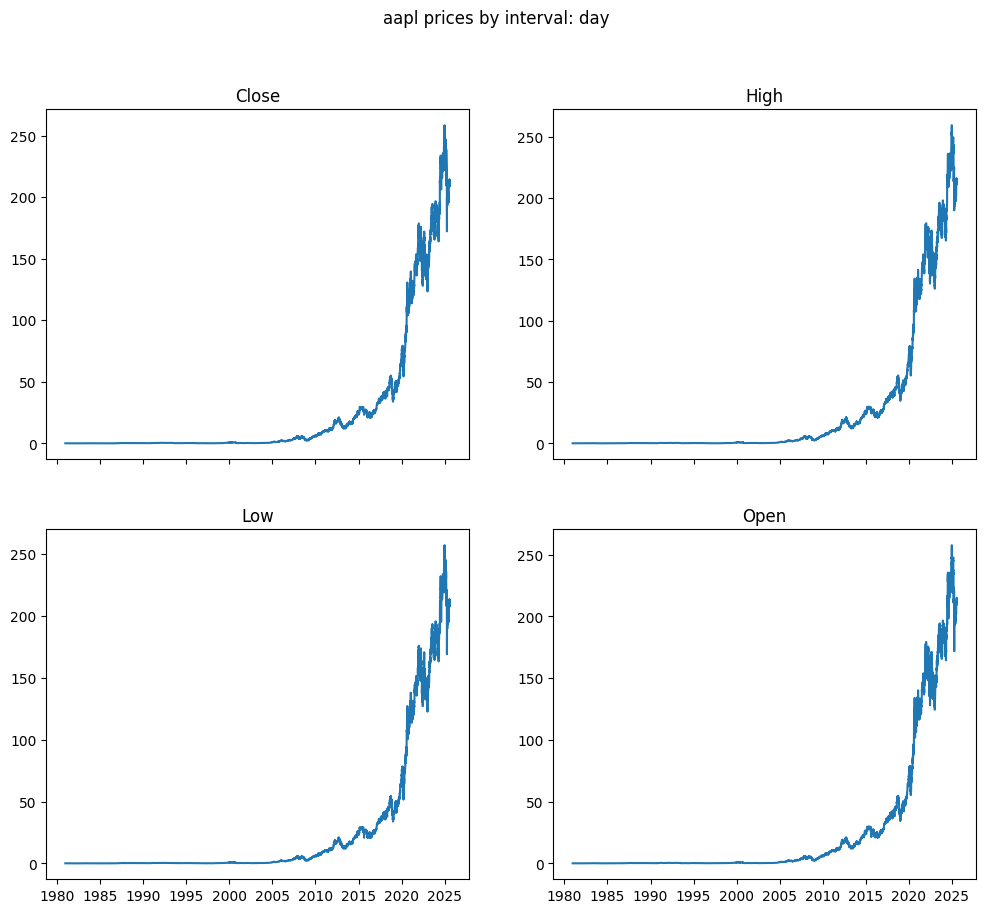

In [55]:
from data.handling import plot_data

plot_data(stock_day,stock=STOCK)

In [56]:
# from data.handling import compute_moving_average2, prices_to_returns2
# stock_day["Returns"] = prices_to_returns2(stock_day["Close"])
# stock_day["ma_10"] = compute_moving_average2()
from data.features import compute_moving_average, compute_day_of_week_feature, compute_moving_average, compute_rolling_std, compute_returns, compute_target

stock_day = stock_day["2005-01-01":].copy()
stock_day["Returns"] = compute_returns(stock_day["Close"].values)
stock_day["Ma (10)"] = compute_moving_average(stock_day["Returns"].values,window = 10)
stock_day["Ma (50)"] = compute_moving_average(stock_day["Returns"].values,window = 50)
stock_day["Ma (100)"] = compute_moving_average(stock_day["Returns"].values,window = 100)
stock_day["Rolling std (20)"] = compute_rolling_std(stock_day["Returns"].values, window=20)
stock_day["Day of week"] = compute_day_of_week_feature(stock_day)
stock_day["RSI"] = ta.rsi(close=stock_day['Close'])
stock_day["Ema"] = ta.ema(close = stock_day["Close"])
stock_day["Target (y)"] = compute_target(stock_day["Returns"].values)


stock_day = stock_day.dropna()
stock_day.head(10)

,Close,High,Low,Open,Volume,Returns,Ma (10),Ma (50),Ma (100),Rolling std (20),Day of week,RSI,Ema,Target (y)
Date,,,,,,,,,,,,,,
2005-05-27,1.218997,1.225910,1.202468,1.221402,316008000,-0.004419,0.018062,0.000202,0.002909,0.022700,4,63.597385,1.165883,0.0
2005-05-31,1.194955,1.224408,1.189544,1.222003,404205200,-0.019723,0.015745,-0.000406,0.002762,0.022764,1,58.681604,1.171169,1.0
2005-06-01,1.211184,1.225008,1.197960,1.198862,453812800,0.013582,0.011529,-0.001136,0.002477,0.023422,2,60.879783,1.178445,0.0
2005-06-02,1.203370,1.211785,1.190146,1.203670,373973600,-0.006452,0.013422,-0.001209,0.002605,0.023364,3,59.245416,1.182976,0.0
2005-06-03,1.149272,1.159490,1.135147,1.146868,956869200,-0.044955,0.011419,-0.000940,0.001813,0.023020,4,49.365218,1.176848,1.0
2005-06-06,1.139655,1.160993,1.128836,1.151978,811966400,-0.008368,0.002153,-0.001709,0.001405,0.025166,0,47.837946,1.170086,0.0
2005-06-07,1.098180,1.133944,1.095475,1.130037,745264800,-0.036393,0.001316,-0.001852,0.001959,0.025089,1,41.827535,1.157012,1.0
2005-06-08,1.109600,1.119518,1.099081,1.100884,404006400,0.010399,-0.008209,-0.002594,0.001456,0.026352,2,43.916952,1.148392,1.0
2005-06-09,1.131540,1.140256,1.106595,1.112005,390255600,0.019773,-0.007018,-0.002020,0.000897,0.026226,3,47.796417,1.145328,0.0


In [57]:
web_scrape_path = fr"C:\RoadToMlGod\stock_predictor\data\articles_{STOCK_NAME}.csv"

sentiment_df = pd.read_csv(web_scrape_path)
sentiment_df["datetime"] = pd.to_datetime(sentiment_df["datetime"])
sentiment_df["date"] = sentiment_df["datetime"].dt.normalize()
sentiment_df.set_index("date", inplace=True)
sentiment_df.drop(columns=["datetime"], inplace=True) #Now index of sentiment data matches feature data (stock_day)


label_to_polarity = {"positive":1, "neutral": 0, "negative":-1}
sentiment_df["polarity"] = sentiment_df["top sentiment"].map(label_to_polarity)

sentiment_df["weighted_sentiment"] = sentiment_df["polarity"] * sentiment_df["sentiment score"]

daily_sentiment = sentiment_df.groupby("date").agg(
    avg_sentiment=("weighted_sentiment", "mean"),
    has_news=("weighted_sentiment", lambda x: int(len(x) > 0))
).reset_index()

daily_sentiment.set_index("date", inplace=True)
sentiment_df.head(10)
daily_sentiment.head(10)



stock_day = stock_day.merge(daily_sentiment, left_index=True, right_index=True, how="left")

stock_day.head(10)


C:\Users\knutr\AppData\Local\Temp\ipykernel_13028\416274670.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment_df["datetime"] = pd.to_datetime(sentiment_df["datetime"])


,Close,High,Low,Open,Volume,Returns,Ma (10),Ma (50),Ma (100),Rolling std (20),Day of week,RSI,Ema,Target (y),avg_sentiment,has_news
Date,,,,,,,,,,,,,,,,
2005-05-27,1.218997,1.225910,1.202468,1.221402,316008000,-0.004419,0.018062,0.000202,0.002909,0.022700,4,63.597385,1.165883,0.0,NaN,NaN
2005-05-31,1.194955,1.224408,1.189544,1.222003,404205200,-0.019723,0.015745,-0.000406,0.002762,0.022764,1,58.681604,1.171169,1.0,NaN,NaN
2005-06-01,1.211184,1.225008,1.197960,1.198862,453812800,0.013582,0.011529,-0.001136,0.002477,0.023422,2,60.879783,1.178445,0.0,NaN,NaN
2005-06-02,1.203370,1.211785,1.190146,1.203670,373973600,-0.006452,0.013422,-0.001209,0.002605,0.023364,3,59.245416,1.182976,0.0,NaN,NaN
2005-06-03,1.149272,1.159490,1.135147,1.146868,956869200,-0.044955,0.011419,-0.000940,0.001813,0.023020,4,49.365218,1.176848,1.0,NaN,NaN
2005-06-06,1.139655,1.160993,1.128836,1.151978,811966400,-0.008368,0.002153,-0.001709,0.001405,0.025166,0,47.837946,1.170086,0.0,NaN,NaN
2005-06-07,1.098180,1.133944,1.095475,1.130037,745264800,-0.036393,0.001316,-0.001852,0.001959,0.025089,1,41.827535,1.157012,1.0,NaN,NaN
2005-06-08,1.109600,1.119518,1.099081,1.100884,404006400,0.010399,-0.008209,-0.002594,0.001456,0.026352,2,43.916952,1.148392,1.0,NaN,NaN
2005-06-09,1.131540,1.140256,1.106595,1.112005,390255600,0.019773,-0.007018,-0.002020,0.000897,0.026226,3,47.796417,1.145328,0.0,NaN,NaN


In [58]:
stock_day["avg_sentiment"] = stock_day["avg_sentiment"].fillna(0.0)
stock_day["has_news"] = stock_day["has_news"].fillna(0).astype(int)

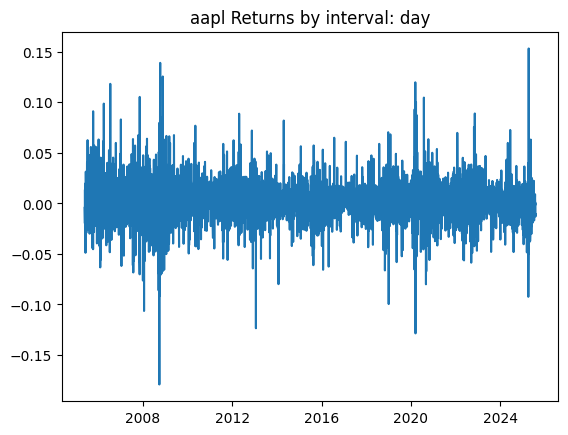

In [59]:
plot_data(stock_day["Returns"],stock=STOCK,single_col=True, title="Returns")

In [60]:
stock_day.head(10)

,Close,High,Low,Open,Volume,Returns,Ma (10),Ma (50),Ma (100),Rolling std (20),Day of week,RSI,Ema,Target (y),avg_sentiment,has_news
Date,,,,,,,,,,,,,,,,
2005-05-27,1.218997,1.225910,1.202468,1.221402,316008000,-0.004419,0.018062,0.000202,0.002909,0.022700,4,63.597385,1.165883,0.0,0.0,0
2005-05-31,1.194955,1.224408,1.189544,1.222003,404205200,-0.019723,0.015745,-0.000406,0.002762,0.022764,1,58.681604,1.171169,1.0,0.0,0
2005-06-01,1.211184,1.225008,1.197960,1.198862,453812800,0.013582,0.011529,-0.001136,0.002477,0.023422,2,60.879783,1.178445,0.0,0.0,0
2005-06-02,1.203370,1.211785,1.190146,1.203670,373973600,-0.006452,0.013422,-0.001209,0.002605,0.023364,3,59.245416,1.182976,0.0,0.0,0
2005-06-03,1.149272,1.159490,1.135147,1.146868,956869200,-0.044955,0.011419,-0.000940,0.001813,0.023020,4,49.365218,1.176848,1.0,0.0,0
2005-06-06,1.139655,1.160993,1.128836,1.151978,811966400,-0.008368,0.002153,-0.001709,0.001405,0.025166,0,47.837946,1.170086,0.0,0.0,0
2005-06-07,1.098180,1.133944,1.095475,1.130037,745264800,-0.036393,0.001316,-0.001852,0.001959,0.025089,1,41.827535,1.157012,1.0,0.0,0
2005-06-08,1.109600,1.119518,1.099081,1.100884,404006400,0.010399,-0.008209,-0.002594,0.001456,0.026352,2,43.916952,1.148392,1.0,0.0,0
2005-06-09,1.131540,1.140256,1.106595,1.112005,390255600,0.019773,-0.007018,-0.002020,0.000897,0.026226,3,47.796417,1.145328,0.0,0.0,0


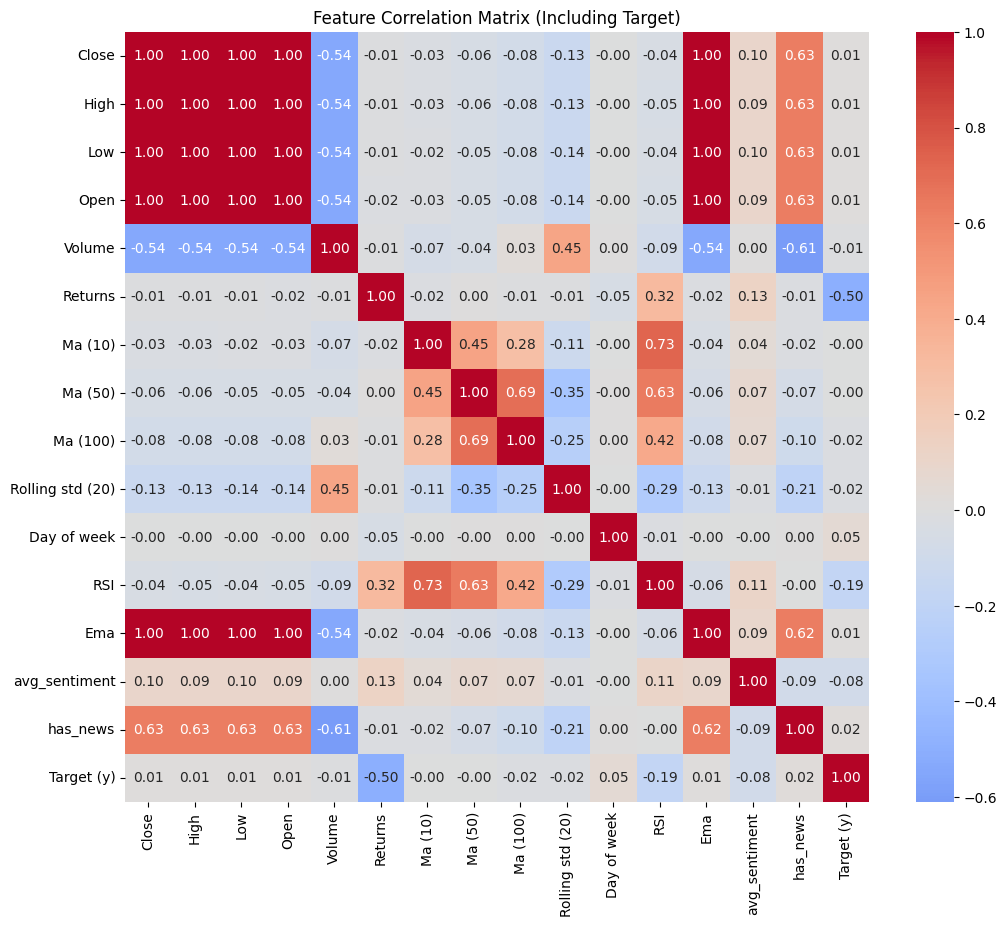

In [61]:
import seaborn as sns

# Select only numeric columns
numeric_features = stock_day.drop(columns=["Target (y)"]).select_dtypes(include="number")

# Add target back temporarily for correlation
correlation_data = numeric_features.copy()
correlation_data["Target (y)"] = stock_day["Target (y)"]

# Compute correlation matrix
corr = correlation_data.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Feature Correlation Matrix (Including Target)")
plt.show()


In [62]:
# stock_day = stock_day.drop(columns=["Open", "High", "Low", "Close"]).copy()


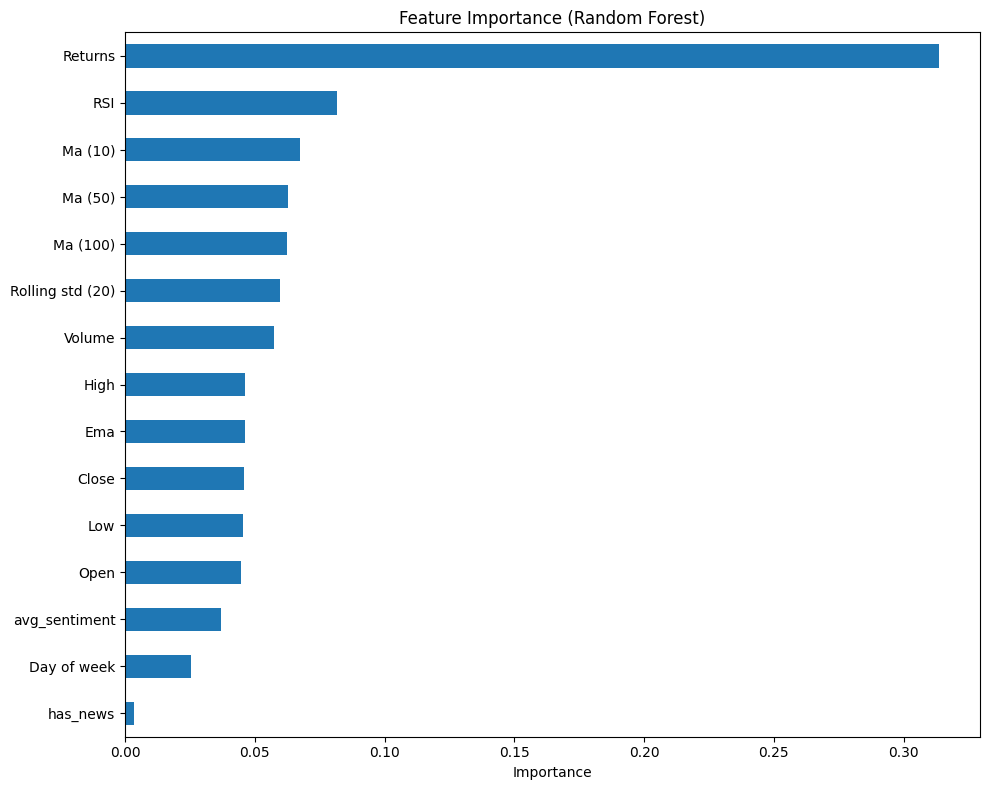

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(stock_day.drop(columns=["Target (y)"]), stock_day["Target (y)"], test_size=0.1, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=stock_day.drop(columns=["Target (y)"]).columns)
importances = importances.sort_values()

# Plot
plt.figure(figsize=(10, 8))
importances.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [64]:
stock_day["rolling_avg_sentiment_3d"] = stock_day["avg_sentiment"].rolling(window=3).mean().fillna(0)

# 2. Sentiment momentum (change from previous day)
stock_day["sentiment_momentum"] = stock_day["avg_sentiment"].diff().fillna(0)

# 3. News burst: how many news articles in last 3 days
stock_day["news_burst_3d"] = stock_day["has_news"].rolling(window=3).sum().fillna(0)

In [65]:
stock_day = stock_day.drop(columns=["Open", "High", "Low", "Close", "Ma (100)"]).copy()


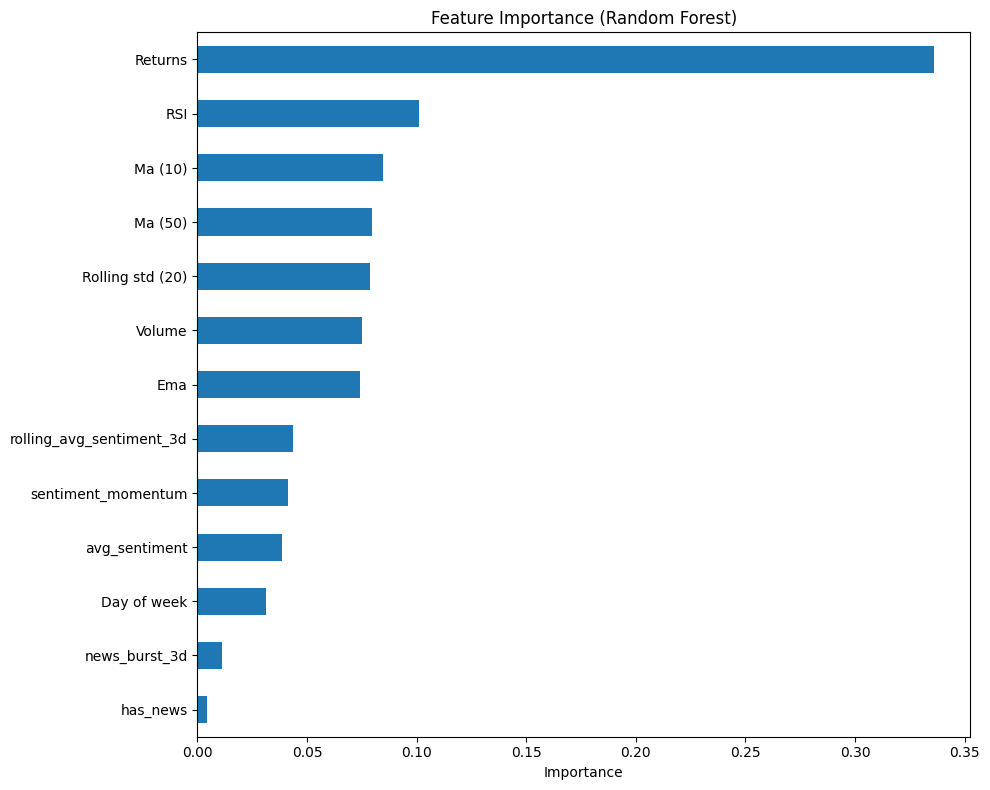

In [66]:
X_train, X_test, y_train, y_test = train_test_split(stock_day.drop(columns=["Target (y)"]), stock_day["Target (y)"], test_size=0.1, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=stock_day.drop(columns=["Target (y)"]).columns)
importances = importances.sort_values()

# Plot
plt.figure(figsize=(10, 8))
importances.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [67]:
stock_day = stock_day.drop(columns=["has_news", "news_burst_3d"])

In [68]:
from models.train_utils import split_train_test

X_train_raw, X_test_raw = split_train_test(stock_day.drop(columns='Target (y)'),split_ratio=0.90)
y_train, y_test = split_train_test(stock_day[['Target (y)']],split_ratio=0.90)
N_features = stock_day.drop(columns="Target (y)").shape[1]

#Standardization:
means = np.mean(X_train_raw, axis=0)
stds = np.std(X_train_raw, axis=0)

X_train_standardized_raw = (X_train_raw - means) / stds
X_test_standardized_raw  = (X_test_raw - means) / stds

print( "Mean and std: ",np.mean(X_train_standardized_raw,axis=0), np.std(X_train_standardized_raw,axis=0))

Mean and std:  Volume                      4.978622e-17
Returns                    -1.555819e-18
Ma (10)                    -1.555819e-17
Ma (50)                     6.223278e-18
Rolling std (20)            1.493587e-16
Day of week                 1.795027e-16
RSI                         2.722684e-16
Ema                        -2.489311e-16
avg_sentiment               1.866983e-17
rolling_avg_sentiment_3d   -1.555819e-17
sentiment_momentum         -6.308362e-18
dtype: float64 Volume                      1.0
Returns                     1.0
Ma (10)                     1.0
Ma (50)                     1.0
Rolling std (20)            1.0
Day of week                 1.0
RSI                         1.0
Ema                         1.0
avg_sentiment               1.0
rolling_avg_sentiment_3d    1.0
sentiment_momentum          1.0
dtype: float64


In [69]:
from models.train_utils import create_series
X_train,y_train = create_series(X_train_standardized_raw, time_step=10)
X_test,y_test = create_series(X_test_standardized_raw, time_step=10)

#Transforming into tensors
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()


#Turning our data into data set and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_dataset),len(train_dataloader)*BATCH_SIZE



c:\RoadToMlGod\stock_predictor\models\train_utils.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(direction[i+time_step])
c:\RoadToMlGod\stock_predictor\models\train_utils.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(direction[i+time_step])


(4557, 4576)

In [70]:

model = LSTM_Model_Classification(N_features, hidden_size=32, num_layers=2,output_size=1)

torch.manual_seed(42)
batch, labels = next(iter(train_dataloader))
print(batch.shape, labels.shape)
out, _ = model.lstm(batch)
out = model.nnLayers(out[:, -1, :])
out.shape


torch.Size([32, 10, 11]) torch.Size([32])


torch.Size([32, 1])

In [71]:
print(np.unique(y_train, return_counts=True))


(array([0., 1.], dtype=float32), array([2319, 2238]))


In [72]:
from models.train_utils import train_step, test_step

pos_weight = torch.tensor([len(y_train[y_train==0])/len(y_train[y_train==1])])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


torch.manual_seed(42)

epochs = 250 
train_hist = []
test_hist = []
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

model.apply(init_weights)


for epoch in range(epochs):
    avg_train_loss, avg_train_acc = train_step(model=model, 
                                optimizer = optimizer, 
                                loss_fn=loss_fn,
                                  data_loader=train_dataloader)
    train_hist.append(avg_train_loss)

    avg_test_loss, avg_test_acc = test_step(model=model, 
                              loss_fn=loss_fn,
                              data_loader=test_dataloader)
    test_hist.append(avg_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}] - Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Training acc: {avg_train_acc}, Test acc: {avg_test_acc}')
        print()







Epoch [10/250] - Training Loss: 0.7076, Test Loss: 0.7086, Training acc: 0.5082369553523399, Test acc: 0.4754774305555556

Epoch [20/250] - Training Loss: 0.7026, Test Loss: 0.7162, Training acc: 0.5389658418504573, Test acc: 0.4583333333333333



KeyboardInterrupt: 